In [26]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    precision_score, recall_score, roc_auc_score
)
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


In [27]:
# Load the dataset
df = pd.read_csv('graded_exams.csv')
print(df.to_string)

<bound method DataFrame.to_string of      student  gender race/ethnicity parental level of education         lunch  \
0          0    male        group A                 high school      standard   
1          1  female        group D            some high school  free/reduced   
2          2    male        group E                some college  free/reduced   
3          3    male        group B                 high school      standard   
4          4    male        group E          associate's degree      standard   
..       ...     ...            ...                         ...           ...   
994      995    male        group C                 high school      standard   
995      996    male        group D          associate's degree  free/reduced   
996      997  female        group C            some high school  free/reduced   
997      998  female        group C                some college      standard   
998      999    male        group A                some college      sta

In [28]:
def prepare_data(subject, df):
    print(f"\nPreparing data for {subject}...")

    # Prepare features and target
    X = df.drop(columns=[f'{subject} grade'])
    X = pd.get_dummies(X, drop_first=True) # Onehot encoding
    y = df[f'{subject} grade']

    # Encode target labels
    label_encoder = LabelEncoder()
    y = label_encoder.fit_transform(y)

    # Split the data
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
    X_test, X_unseen, y_test, y_unseen = train_test_split(X_temp, y_temp, test_size=1/3, random_state=42, stratify=y_temp)

    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    X_unseen_scaled = scaler.transform(X_unseen)

    return X_train_scaled, X_test_scaled, X_unseen_scaled, y_train, y_test, y_unseen

In [29]:
def train_and_evaluate_svm(X_train, y_train):
    print("Training SVM with cross-validation...")
    svm_model = SVC(kernel='rbf', C=1.0, gamma='scale', class_weight='balanced', random_state=42, probability=True)
    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    cross_val_acc = cross_val_score(svm_model, X_train, y_train, cv=cv, scoring='accuracy')
    print(f"Cross-validation Accuracy (Mean): {np.mean(cross_val_acc):.4f}")

    # Train final model
    svm_model.fit(X_train, y_train)
    return svm_model

In [30]:
def evaluate_model(model, X, y, dataset_name, subject):
    y_pred = model.predict(X)
    y_proba = model.predict_proba(X)

    print(f"\n{subject} {dataset_name} Evaluation:")
    print("Accuracy:", accuracy_score(y, y_pred))
    print("Precision:", precision_score(y, y_pred, average='weighted'))
    print("Recall:", recall_score(y, y_pred, average='weighted'))
    print("F1 Score:", f1_score(y, y_pred, average='weighted'))
    print("ROC-AUC:", roc_auc_score(y, y_proba, multi_class='ovr'))

    # Confusion matrix
    plt.figure(figsize=(6, 5))
    sns.heatmap(confusion_matrix(y, y_pred), annot=True, fmt='d', cmap='Greens' if dataset_name == 'Test' else 'Oranges')
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix - {subject} {dataset_name} Set")
    plt.show()

In [31]:
def process_subject(subject, df):
    X_train, X_test, X_unseen, y_train, y_test, y_unseen = prepare_data(subject, df)
    model = train_and_evaluate_svm(X_train, y_train)

    evaluate_model(model, X_test, y_test, 'Test', subject)
    evaluate_model(model, X_unseen, y_unseen, 'Unseen', subject)


Preparing data for math...
Training SVM with cross-validation...
Cross-validation Accuracy (Mean): 0.5952

math Test Evaluation:
Accuracy: 0.555
Precision: 0.661391668847026
Recall: 0.555
F1 Score: 0.5972912554068569
ROC-AUC: 0.874597531000251


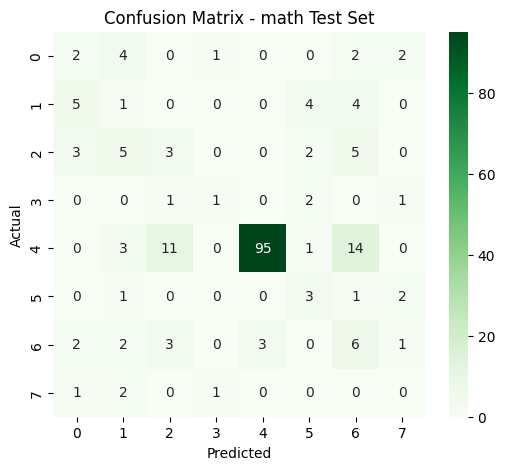


math Unseen Evaluation:
Accuracy: 0.63
Precision: 0.6983559577677224
Recall: 0.63
F1 Score: 0.6519592796583947
ROC-AUC: 0.8967193813673819


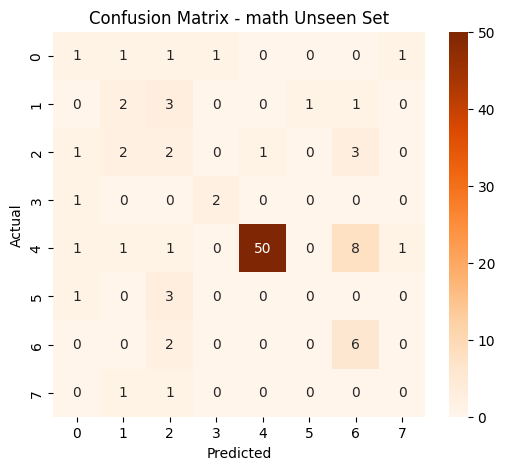

In [33]:
process_subject('math', df)


Preparing data for reading...
Training SVM with cross-validation...
Cross-validation Accuracy (Mean): 0.5937

reading Test Evaluation:
Accuracy: 0.63
Precision: 0.7069243633113602
Recall: 0.63
F1 Score: 0.6576477937232628
ROC-AUC: 0.9257363117193533


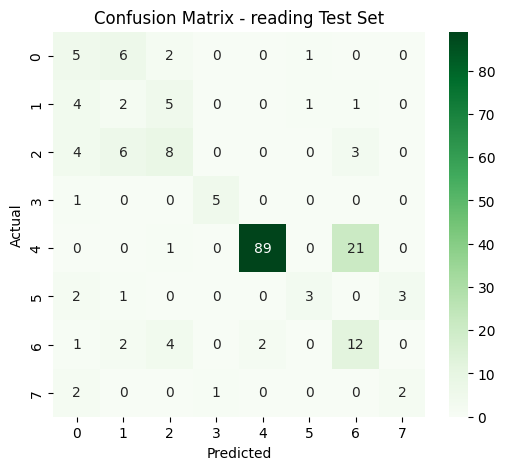


reading Unseen Evaluation:
Accuracy: 0.64
Precision: 0.7244232569598422
Recall: 0.64
F1 Score: 0.6623837526852233
ROC-AUC: 0.9424510390603795


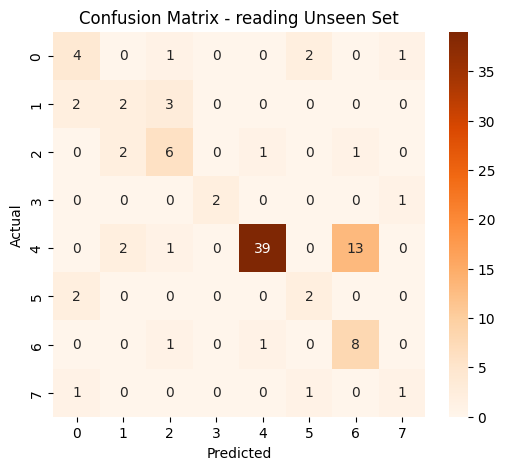

In [34]:
process_subject('reading', df)


Preparing data for writing...
Training SVM with cross-validation...
Cross-validation Accuracy (Mean): 0.6710

writing Test Evaluation:
Accuracy: 0.665
Precision: 0.7392087985114302
Recall: 0.665
F1 Score: 0.690542796529035
ROC-AUC: 0.9241660280214621


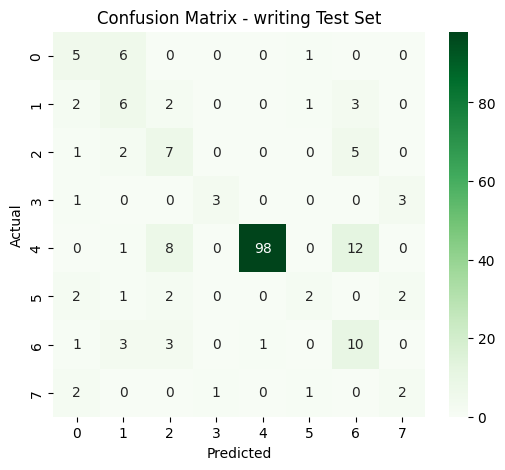


writing Unseen Evaluation:
Accuracy: 0.65
Precision: 0.7558333333333332
Recall: 0.65
F1 Score: 0.687376859580143
ROC-AUC: 0.9040185496328148


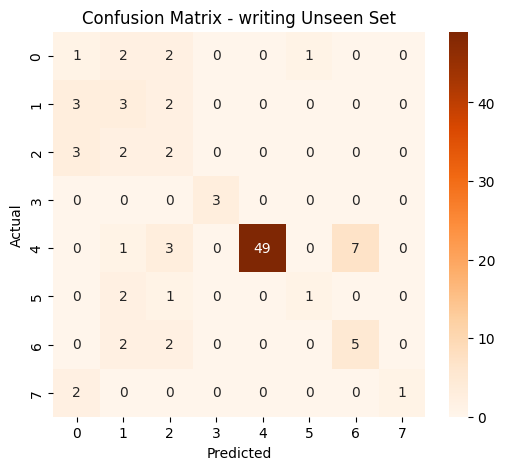

In [35]:
process_subject('writing', df)